## Milestone 2 Part A 
---

The main goal of this milestone is to perform a classification with LSTM on the dataset assigned to your group.

The outcome of this milestone is to design, implement, and refine a LSTM machine learning model using Keras' LSTM to predict a given gesture.

# 0 MEANS TURN GESTURE and 1 MEANS CIRCLE

The following pair of gesture datasets are assigned to 

(a) Turn left and turn right: Team #4

b) Turn  and circle : Team #3

c) Stop  and no : Team #2

d) Hello  and abort : Team #1

### Main tasks
1) Prepare the polar angle dataset so that it is ready for Keras LSTM model

V1.1) Format and prepare the data and randomly split it into 80% for training and 20% for testing

1.2) Prepare your training datasets, name them as X_train.txt and y_train.txt, and then put them under the data/data_for_lstm/train 

1.3) Prepare your testing datasets, name them as X_train.txt and y_train.txt, and then put them under the data/data_for_lstm/test 

2) Create a LSTM model with Keras

V2.1) Vary the number of LSTM and layers and comment on how this would affect the gesture classification rate

V2.2) Vary the dropout rate(s) to see how this would affect the gesture classification rate and the CPU time taken to execute the process.

3) Repeat (1) - (2) with the polar angular velocity dataset

4) Repeat (1) - (2) with both the polar angle and the polar angular velocity datasets

5) Comment, with reasons, on (1)-(4)


**Please provide the online discussion forum info here**

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Everyone must put the copied folder in the exact path shown below so you collaborate and get graded easily.   
**No project score will be given for not following this folder configuration**    
(Our grader is *not reponsible to figure out your own* perferred Google *folder* configuration)   
**Only LSTM using Keras should be used in this milestone**

In [3]:
root_path = "./drive/My Drive/CS256Project/data/data_for_lstm"

(os.path.exists(root_path)) #Checking if the data paths indeed exist and are valid.

True

- Import libraries and models needed for this work

In [13]:
# lstm model
# from numpy import mean
# from numpy import std
# from numpy import dstack
# from numpy import load
import numpy as np
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Masking
from keras import backend
from keras.utils.np_utils import to_categorical
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import os

## Prepare your X_train.txt, y_train.txt, X_test.txt, y_test.txt

In [5]:
## your code here
from sklearn.model_selection import train_test_split

# Return a list of numpy objects where each object represents one video 
def load_files(gesture):
  video = []
  filenames = os.listdir(os.path.join("./drive/My Drive/CS256Project/data/gestures_basic_d2", gesture))
  for filename in filenames:
    # print(np.load(os.path.join('./drive/My Drive/CS256Project/data/gestures_basic_d2',gesture, filename), allow_pickle=True)['keypoints'].shape)
    video.append(np.load(os.path.join('./drive/My Drive/CS256Project/data/gestures_basic_d2',gesture, filename), allow_pickle=True)['keypoints'])
    # break
  return video

def create_files(filepath):
  
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values

In [6]:
MIN_JOINT = 5
MAX_JOINT = 10
MIN_NUM_FRAMES = 72
# Move the origin to nose
def updateCoord(frame):
  return frame - frame[0]


def getPolar(frame):
  tmp = []
  for i in range(1, len(frame)):
    tmp.append(np.arctan2(frame[i][1], frame[i][0]))
  return tmp


def getVelocity(polars):
  # deprecated
  # the second dimension is 6 since we're just keeping the hand movements, which there will be 6 joints in total
  # Min_Joint and Max_Joint keep the indices of the joints we need

  ########### NEEDS PADDING ###########
  # consider changing 0 to a different value beyond angle range 
  velocity = [[0 for _ in range(MAX_JOINT - MIN_JOINT + 1)] for _ in range(len(polars))]
  for frame in range(1, len(polars)):
    for joint in range(MAX_JOINT - MIN_JOINT + 1):
      velocity[frame][joint] = polars[frame][joint] - polars[frame-1][joint]
  return velocity

# Prepares features and target into the right format
def read_polar(gesture0, gesture1):
  X_0_raw = load_files(gesture0)
  X_0 = []
  for video in X_0_raw:
    polar = []
    for frame in range(len(video)):
      coord = video[frame][1][0].transpose(1, 0)
      polar.append(getPolar(updateCoord(coord))[MIN_JOINT:MAX_JOINT+1])
    velocity = getVelocity(polar)
    features = np.zeros((MIN_NUM_FRAMES, MAX_JOINT - MIN_JOINT + 1, 2))
    features[:len(video), :, 0] = polar
    features[:len(video), :, 1] = velocity
    
    X_0.append(features)
  y_0 = [0 for _ in range(len(X_0))]

  X_1_raw = load_files(gesture1)
  X_1 = []
  for video in X_1_raw:
    polar = []
    for frame in range(len(video)):
      coord = video[frame][1][0].transpose(1, 0)
      polar.append(getPolar(updateCoord(coord))[MIN_JOINT:MAX_JOINT+1])
    velocity = getVelocity(polar)
    features = np.zeros((MIN_NUM_FRAMES, MAX_JOINT - MIN_JOINT + 1, 2))
    features[:len(video), :, 0] = polar
    features[:len(video), :, 1] = velocity
    X_1.append(features)
  y_1 = [1 for _ in range(len(X_1))]

  return np.array(X_0 + X_1, dtype = object), np.array(y_0 + y_1)



In [7]:
X, y = read_polar('turn', 'circle')
# X will be storing m videos, each with n frames, while each frames have 17 joints
# y will be an array looking like [[0] * j, [1] * k] where j is the number of first gesture and k will be the number of second gesture

In [8]:
# Prepares traning and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
np.array(X_train, dtype=object).shape, np.array(X_test, dtype=object).shape

((98, 72, 6, 2), (25, 72, 6, 2))

In [ ]:
len(y_train), len(y_test)

(98, 25)

- You may modify the code below for you specific project needs

In [9]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, neurons=50, drop_out_rate = 0.5, lstm_layers = 1, dropout_layers = 1, summary = True):
	verbose, epochs, batch_size = 0, 15, 64
	trainX = trainX.astype('float32')
	testX = testX.astype('float32')
	n_timesteps, n_features, n_outputs = MIN_NUM_FRAMES, MAX_JOINT - MIN_JOINT + 1, 2
	model = Sequential()
	########## Needs Masking #########
	for _ in range(lstm_layers - 1):
		model.add(LSTM(neurons, input_length=trainX.shape[1], input_dim=trainX.shape[2], return_sequences = True))
	model.add(LSTM(neurons, input_length=trainX.shape[1], input_dim=trainX.shape[2]))
 
	for _ in range(dropout_layers):
		model.add(Dropout(drop_out_rate))
		model.add(Dense(100, activation='relu'))
	
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
	# fit network
	if(summary):
		model.summary()
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# model.fit(trainX, trainy)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
	return accuracy

In [ ]:
# Clears backend keras session: https://stackoverflow.com/questions/55299510/cpu-usage-and-time-until-training-starts-increasing-on-each-model-fit-in-keras/55300684
backend.clear_session()

print('+-----------+')
print('|Polar angle|')
print('+-----------+')
Polar_train, Polar_test = X_train[:, :, :, 0], X_test[:, :, :, 0]
plot_num_neurons, accuracy = [], []
for neurons in range(50, 1001, 50):
  plot_num_neurons.append(neurons)
  backend.clear_session()
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= 1, dropout_layers = 1, summary = False)
  accuracy.append(acc)
  # print('\t{0} neurons have accuracy {1:.2f}'.format(neurons, acc))

plt.subplot(1, 4, 1) # row 1, col 2 index 1
plt.plot(plot_num_neurons, accuracy)
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')



plot_dropout, accuracy = [], []
for dropout_rate in np.arange(0.0, 1.0, 0.1):
  plot_dropout.append(dropout_rate)
  backend.clear_session()
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = 50, drop_out_rate = dropout_rate, lstm_layers= 1, dropout_layers = 1, summary = False)
  accuracy.append(acc)

plt.subplot(1, 4, 2) # index 2
plt.plot(plot_dropout, accuracy)
plt.xlabel('Dropout rate')

plot_LSTM, accuracy = [], []
for layers in np.arange(1, 6, 1):
  plot_LSTM.append(layers)
  backend.clear_session()
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = 50, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
  accuracy.append(acc)

plt.subplot(1, 4, 3) # index 3
plt.plot(plot_LSTM, accuracy)
plt.xlabel('LSTM layers')

plot_dropout_layer, accuracy = [], []
for layers in np.arange(1, 6, 1):
  plot_dropout_layer.append(layers)
  backend.clear_session()
  # %%time
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = 50, drop_out_rate = 0.5, lstm_layers= 1, dropout_layers = layers, summary = False)
  accuracy.append(acc)

plt.subplot(1, 4, 4) # index 4
plt.plot(plot_dropout_layer, accuracy)
plt.xlabel('Dropout layers')

plt.show()

In [ ]:
# commit: 'Changing #layer and #neuron'
print('+-----------+')
print('|Polar angle|')
print('+-----------+')
Polar_train, Polar_test = X_train[:, :, :, 0], X_test[:, :, :, 0]


lstm = []
layer_gen = range(1, 11)
neuron_gen = range(50, 1001, 30)
for layers in layer_gen:
  row = []
  print(layers, end = '')
  for neurons in tqdm(neuron_gen):
    backend.clear_session()
    acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
    row.append(acc)
  lstm.append(row)

plt.figure(figsize=(30, 10))
sns.heatmap(lstm, linewidth=0.5, xticklabels= [i for i in neuron_gen], yticklabels=[i for i in layer_gen], annot = True)
plt.xlabel('Neurons')
plt.ylabel('Layers')
plt.title('LSTM layer')
plt.savefig('./drive/My Drive/CS256Project/LSTM_layer_heatmap-20211114.png')
np.savetxt("./drive/My Drive/CS256Project/LSTM_layer-20211114.csv", lstm, delimiter=",")

+--------+
|Velocity|
+--------+
	30 neurons have accuracy 0.88
	40 neurons have accuracy 0.88
	50 neurons have accuracy 0.84
	60 neurons have accuracy 0.88
	70 neurons have accuracy 0.84
	80 neurons have accuracy 0.84
	90 neurons have accuracy 0.88
	100 neurons have accuracy 0.84


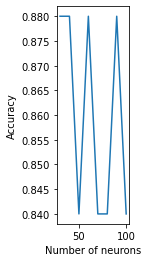

In [ ]:
backend.clear_session()
print('+--------+')
print('|Velocity|')
print('+--------+')
Velocity_train, Velocity_test = X_train[:, :, :, 1], X_test[:, :, :, 1]
plot_num_neurons, accuracy = [], []
for neurons in range(30, 110, 10):
  plot_num_neurons.append(neurons)
  backend.clear_session()
  acc = evaluate_model(Velocity_train, y_train, Velocity_test, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= 1, dropout_layers = 1, summary = False)
  accuracy.append(acc)
  print('\t{0} neurons have accuracy {1:.2f}'.format(neurons, acc))

plt.subplot(1, 4, 1) # row 1, col 2 index 1
plt.plot(plot_num_neurons, accuracy)
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')

# Goes with 40 neurons for now 
# plot_LSTM, accuracy = [], []
# for layers in np.arange(1, 6, 1):
#   plot_LSTM.append(layers)
#   backend.clear_session()
#   acc = evaluate_model(Velocity_train, y_train, Velocity_test, y_test, neurons = 40, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
#   accuracy.append(acc)
#   print('\t{0} layers have accuracy {1:.2f}'.format(layers, acc))

# plt.subplot(1, 4, 3) # index 3
# plt.plot(plot_LSTM, accuracy)
# plt.xlabel('LSTM layers')

# plot_dropout_layer, accuracy = [], []
# for layers in np.arange(1, 6, 1):
#   plot_dropout_layer.append(layers)
#   backend.clear_session()
#   acc = evaluate_model(Velocity_train, y_train, Velocity_test, y_test, neurons = 40, drop_out_rate = 0.5, lstm_layers= 4, dropout_layers = layers, summary = False)
#   accuracy.append(acc)
#   print('\t{0} dense layers have accuracy {1:.2f}'.format(layers, acc))

# plt.subplot(1, 4, 4) # index 2
# plt.plot(plot_dropout_layer, accuracy)
# plt.xlabel('Dropout layers')

# plot_dropout, accuracy = [], []
# for dropout_rate in np.arange(0.0, 1.1, 0.1):
#   plot_dropout.append(dropout_rate)
#   %%time
#   backend.clear_session()
#   acc = evaluate_model(Velocity_train, y_train, Velocity_test, y_test, neurons = 40, drop_out_rate = dropout_rate, lstm_layers= 4, dropout_layers = 1, summary = False)
#   accuracy.append(acc)
#   print('\t{0} dropout rate have accuracy {1:.2f}'.format(dropout_rate, acc))


# plt.subplot(1, 4, 2) # index 2
# plt.plot(plot_dropout, accuracy)
# plt.xlabel('Dropout rate')


plt.show()

In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [ ]:
# run an experiment
def run_experiment(max_lstm=1001):
	# load data
	trainX, trainy, testX, testy = load_dataset(prefix=root_path)
	# repeat experiment
	scores = list()
	for r in range(100,max_lstm,100):
		score = evaluate_model(trainX, trainy, testX, testy,max_lstm)
		score = score * 100.0
		print('> with %d LSTMs: %.3f' % (r, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [ ]:
%%time
# run the experiment
run_experiment()

filenames: ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt', 'body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
(7352, 128, 9) (7352, 1)
filenames: ['total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt', 'body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
(2947, 128, 9) (2947, 1)
[samples, time steps, features] (7352, 128, 9) (7352, 6) [samples, time steps, features] (2947, 128, 9) (2947, 6)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1001)              4048044   
                                                                 
 dropout_4 (Dropout)         (None, 1001)              0         
                         

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print('[samples, time steps, features]',trainX.shape, trainy.shape, '[samples, time steps, features]',testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	print('filenames:', filenames)
  # print('filenames shape:', filenames.shape)

	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y